In [3]:
from segment_anything import sam_model_registry
from segment_anything import SamAutomaticMaskGenerator,SamPredictor

device = "cuda"
# load default model
sam = sam_model_registry["vit_h"](checkpoint="./checkpoint/sam_vit_h_4b8939.pth")
sam.to(device=device)
mask_generator = SamPredictor(sam)


In [4]:
import nibabel as nib
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
img1_path = "imagesTr/img0001.nii.gz"
img = nib.load(img1_path)

# 获取图像数据
data = img.get_fdata()

test_img = data[:,:,100]

input_img = np.zeros((test_img.shape[0],test_img.shape[1],3))
print(input_img.shape)
input_img[:,:,0] = input_img[:,:,1] = input_img[:,:,2] = (test_img-np.min(test_img))/(np.max(test_img))*255
#input_img[:,:,3] = np.ones((test_img.shape[0],test_img.shape[1]))
input_img = input_img.astype("uint8")

#masks = mask_generator.generate(input_img)

(512, 512, 3)


In [5]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))   

In [6]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

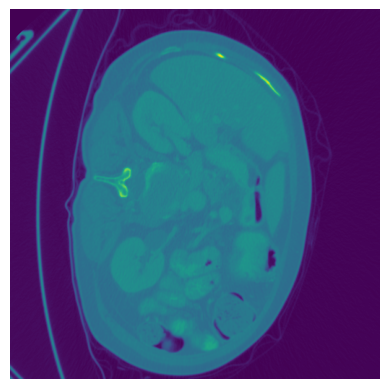


<class 'nibabel.nifti1.Nifti1Image'>
data shape (512, 512, 147)
affine:
[[  -0.66796875    0.            0.          170.66601562]
 [   0.            0.66796875    0.         -170.66601562]
 [   0.            0.            3.         -219.        ]
 [   0.            0.            0.            1.        ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 512 512 147   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1.         0.66796875 0.66796875 3.         0.         0.
 0.         0.        ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min      

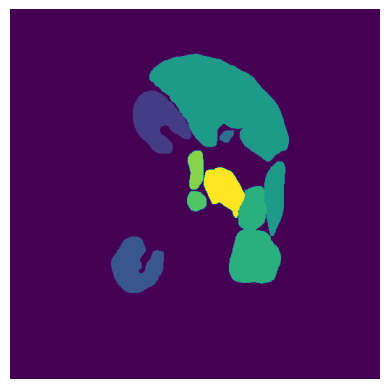

In [7]:
plt.imshow(test_img)
#show_anns(masks)
plt.axis('off')
plt.show() 

label1_path = "labelsTr/label0001.nii.gz"
print(nib.load(label1_path))
lab_img = nib.load(label1_path).get_fdata()
labimg = lab_img[:,:,100]
plt.imshow(labimg)
plt.axis('off')
plt.show()

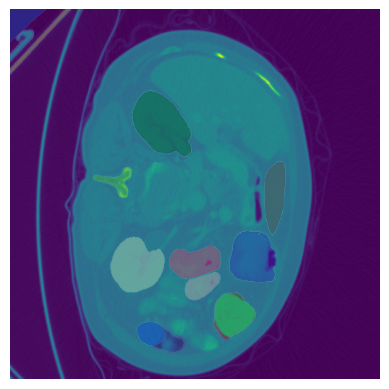

1140
4151
2488
5066
856
551
1710
966
1235
2214
764
2391
2701
682
3788


In [6]:
actual_masks = []
for mask in masks:
    if mask["area"] >= 500 and mask["area"] <= 100000:
        # 选出大小比较正常的图像
        actual_masks.append(mask)
        #print(mask["segmentation"].astype("uint8"))
        #plt.show()
plt.imshow(test_img)
show_anns(actual_masks)
plt.axis('off')
plt.show() 
for am in actual_masks:
    print(am["area"])


mdice = 


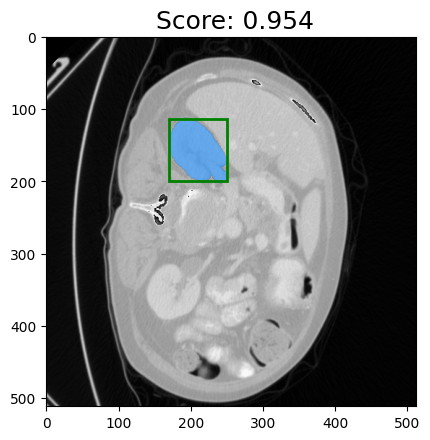

0.8954452460428556


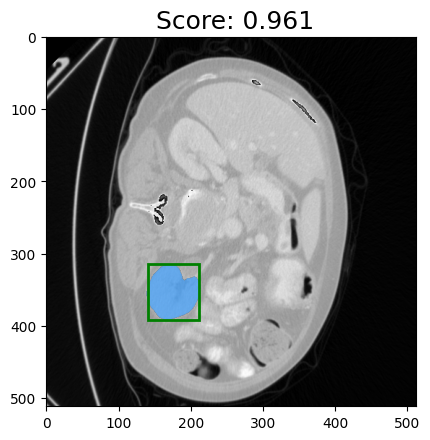

0.9408472204554128


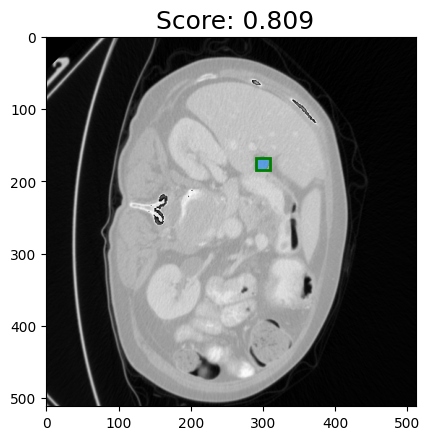

0.8702290076335878


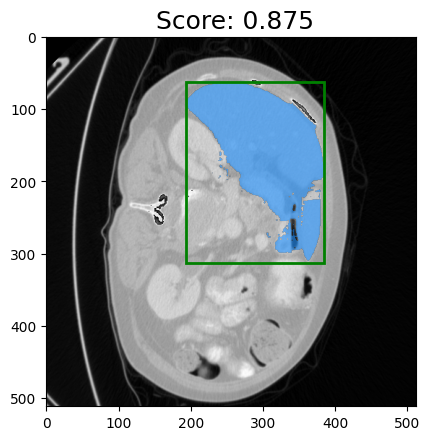

0.8358851787869466


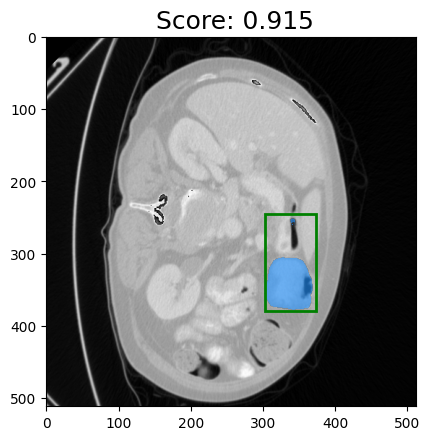

0.7775828460038986


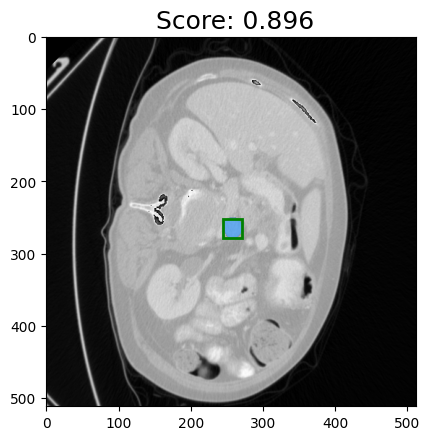

0.942323314378554


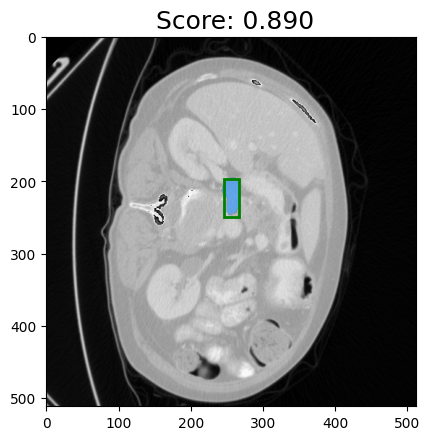

0.9115572436245253


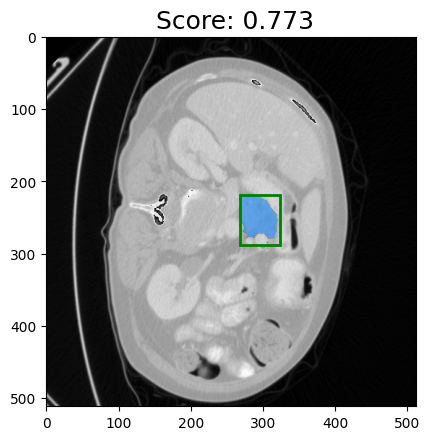

0.8870737186032265
0.8826179719411259


In [39]:
def mDice(image,Ground_truth_mask,predictor,prompt = "box"):
    predictor.set_image(image)
    Dice_lst = []
    local_gt = Ground_truth_mask.astype("uint8")
    if np.max(local_gt) == 0:
        return 1
    for i in range(1,np.max(local_gt)+1):
        i_gt_mask = np.where(local_gt == i, 1, 0)
        if np.sum(i_gt_mask.flatten()) == 0:
            continue
        else:
            if prompt == "point":
                # 随机选一个点
                indices = np.nonzero(i_gt_mask)
                random_index = np.random.randint(0,len(indices[0])-1)
                point = np.array([(indices[1][random_index],indices[0][random_index])])
                SAM_mask , scores, logits = predictor.predict(point_coords=point,point_labels=np.array([1]),multimask_output=False,)
                
                #fig, ax = plt.subplots(1,1)
                #plt.imshow(image)
                #show_mask(SAM_mask,ax=ax)
                #show_points(coords=points,labels=np.ones(len(points)),ax=ax)
                #plt.title(f" Score: {scores[0]:.3f}", fontsize=18)
                #plt.show()

            elif prompt == "points":
                # 随机选5个点
                indices = np.nonzero(i_gt_mask)
                random_index = np.random.random_integers(0,len(indices[0])-1,5)
                points = []
                for j in range(len(random_index)):
                    points.append((indices[1][random_index[j]],indices[0][random_index[j]]))
                points = np.array(points)
                SAM_mask , scores, logits = predictor.predict(point_coords=points,point_labels=np.ones(len(points)),multimask_output=False,)
                
                #fig, ax = plt.subplots(1,1)
                #plt.imshow(image)
                #show_mask(SAM_mask,ax=ax)
                #show_points(coords=points,labels=np.ones(len(points)),ax=ax)
                #plt.title(f" Score: {scores[0]:.3f}", fontsize=18)
                #plt.show()

                
            else:
                indices = np.nonzero(i_gt_mask)
                x_min = min(indices[1])
                x_max = max(indices[1])
                y_min = min(indices[0])
                y_max = max(indices[0])
                input_box = np.array([x_min,y_min,x_max,y_max])
                SAM_mask , scores, logits = predictor.predict(point_coords=None,point_labels=None,box=input_box,multimask_output=False,)

                #fig, ax = plt.subplots(1,1)
                #plt.imshow(image)
                #show_mask(SAM_mask,ax=ax)
                #show_box(input_box, ax)
                #plt.title(f" Score: {scores[0]:.3f}", fontsize=18)
                #plt.show()
            Dice_lst.append(Dice(SAM_mask,i_gt_mask))
            print(Dice_lst[-1])
        
    return sum(Dice_lst) / len(Dice_lst)

def Dice(SAM_mask,i_gt_mask):
    output_mat = SAM_mask * i_gt_mask
    overlap = np.sum(output_mat)
    return 2* overlap / (np.sum(SAM_mask)+np.sum(i_gt_mask))

print("mdice = ")
print(mDice(input_img,labimg,mask_generator))

In [ ]:
import json
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import nibabel as nib
from pycocotools import mask as mask_utils


# load datasets

with open("./data/dataset_0.json") as file1:
    dataset = json.load(file1)
#test = dataset["test"]
training = dataset["training"]
validation = dataset["validation"]


# load imgs and labels
i = 0
for data in training:
    i+= 1
    img_path, label_path = data["image"], data["label"]
    image = nib.load(img_path)
    label = nib.load(label_path)
    print(label)
    image_img_data = image.get_fdata()
    label_img_data = label.get_fdata()
    num_slice = label.shape[-1]
    for i in range(num_slice):
        ground_truth = label_img_data[:,:,i]
        SAM_segmentation = mask_generator.generate(input_img)





<class 'nibabel.nifti1.Nifti1Image'>
data shape (512, 512, 147)
affine:
[[  -0.66796875    0.            0.          170.66601562]
 [   0.            0.66796875    0.         -170.66601562]
 [   0.            0.            3.         -219.        ]
 [   0.            0.            0.            1.        ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 512 512 147   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1.         0.66796875 0.66796875 3.         0.         0.
 0.         0.        ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min      

NameError: name 'mask_generator' is not defined

In [ ]:
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set_style('darkgrid')

img1_path = "labelsTr/label0001.nii.gz"

img = nib.load(img1_path)

# 获取图像数据
data = img.get_fdata()

# 可视化每一层切片
num_slices = data.shape[-1]

# 设置子图的行数和列数
num_rows = num_slices // 10 + 1  # 每行显示10个切片
num_cols = min(num_slices, 10)

# 设置子图的大小
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

# 遍历每一层切片并可视化
for i in range(num_slices):
    row_idx = i // 10
    col_idx = i % 10

    # 在子图中显示每一层切片
    axes[row_idx, col_idx].imshow(data[:, :, i], cmap='gray')
    axes[row_idx, col_idx].axis('off')  # 关闭坐标轴

# 如果切片数量不是10的倍数，隐藏多余的子图
for i in range(num_slices, num_rows * num_cols):
    row_idx = i // 10
    col_idx = i % 10
    fig.delaxes(axes[row_idx, col_idx])

plt.show()
